<a href="https://colab.research.google.com/github/stellaw1/400q-project/blob/main/400q_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups

### Installations
We trained our models using `tensorflow-quantum`, a quantum machine learning library that builds off of the popular `tensorflow` ML framework and `Cirq` for quantum circuit designs

In [ ]:
!pip install pennylane
!pip install tensorflow==2.7.0
!pip install tensorflow-quantum==0.7.2
!pip install cirq

### Imports

In [269]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py'>

In [271]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy

In [332]:
# visualization tools

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

from matplotlib import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# Data

### Data Generation

TODO

In [324]:
def generate_spt_data():
  step = np.pi / 80

  h = 0 
  g = 0

  # while h < np.pi / 2:
  while g < np.pi:
      coeffs = [-1, -1, -h, -h, -h, -h, -g, -g]
      ops = [qml.PauliZ(0) @ qml.PauliX(1) @ qml.PauliZ(2), qml.PauliZ(1) @ qml.PauliX(2) @ qml.PauliZ(3), 
            qml.PauliX(0), qml.PauliX(1), qml.PauliX(2), qml.PauliX(3), 
            qml.PauliX(0) @ qml.PauliX(1) @ qml.PauliX(2), qml.PauliX(1) @ qml.PauliX(2) @ qml.PauliX(3)]

      H = qml.Hamiltonian(coeffs, ops)
      # print(H)
      print(min(qml.eigvals(H)))
      # h += step
      g += step

In [ ]:
generate_spt_data()

In [326]:
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

# Layer Definition

### One / Two Qubit Unitary
Basic building block of the QCNN and bQCNN defined below, this closely follows the circuit figures described in the bQCNN paper by MacCormack Et al. 

In [346]:
def one_qubit_unitary(bit, symbols):
    """
    SU(2) one qubit unitary
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])

def controlled_one_qubit_unitary(control_bit, target_bit, symbols):
    """ 
    Controlled version of the SU(2) one qubit unitary
    """
    return cirq.Circuit(
        cirq.X(target_bit).controlled_by(control_bit)**symbols[0],
        cirq.Y(target_bit).controlled_by(control_bit)**symbols[1],
        cirq.Z(target_bit).controlled_by(control_bit)**symbols[2])

def two_qubit_unitary(bits, symbols):
    """
    SU(4) two qubit unitary as described in Figure 6 of the bQCNN paper
    """
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    # circuit += [cirq.ZZ(*bits)**symbols[6]]
    # circuit += [cirq.YY(*bits)**symbols[7]]
    # circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += [
      cirq.CNOT(bits[0], bits[1]),
      cirq.Ry(rads=symbols[6])(bits[0]), 
      cirq.Rz(rads=symbols[7])(bits[1]), 
      cirq.CNOT(bits[1], bits[0]),
      cirq.Ry(rads=symbols[8])(bits[0]),
      cirq.CNOT(bits[0], bits[1]),
    ]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit

defined circuits drawn using `SVGCircuit` library

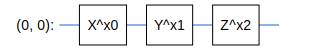

In [348]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

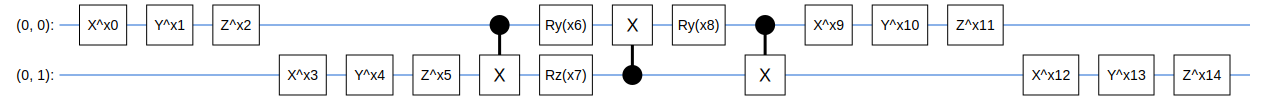

In [334]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

### Convolution Layers

Definition for the quantum convolution, pooling, and **branching** layers

In [284]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for i in range(1,len(bits)):
        circuit += two_qubit_unitary([bits[i-1], bits[i]], symbols[(i-1)*15:i*15])
    return circuit

The basic convolution layer entangles qubits next to each other using the `two_qubit_unitary` gate defined earlier

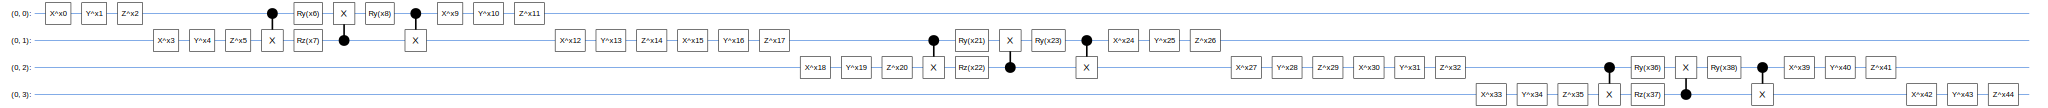

In [335]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 4), sympy.symbols('x0:45')))

In [286]:
def quantum_branch_pool_circuit(qubits, symbols):
  """ 'pooling' layer of the 4-Qbit bQCNN: controlled one qubit unitary applied
  to qubits right before measurement
  """
  return cirq.Circuit(
    controlled_one_qubit_unitary(qubits[0], qubits[2], symbols[0:3]),
    controlled_one_qubit_unitary(qubits[1], qubits[3], symbols[3:6]))

The pooling layer is simply a controlled version of the `one_qubit_unitary` circuit defined earlier. The control wires are the wires that are being pooled away (i.e. measured) and the target wires are applied the rotations 

Below circuit will measure qubits 0 and 1 and keep qubits 2 and 3

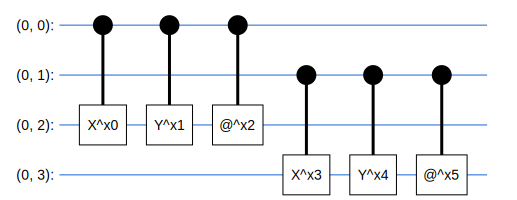

In [336]:
test_bits = cirq.GridQubit.rect(1,4)

SVGCircuit(
    quantum_branch_pool_circuit(test_bits, sympy.symbols('x0:111')))

The quantum **branching** layer containing distinct layers of quantum convolution layers where the choice of which branch to enter is decided by the measurement outcome of the measurement qubits.

This is achieved by applying controls based on the measurement outcomes of the measurement wires. For 4 qubits, the lower 2 qubits are the measurement qubits and their outcome controls which of the 4 branches the upper 2 qubits enter. 

In [349]:
def quantum_branch_conv_circuit(qubits, symbols):

    L = len(qubits)

    circuit = cirq.Circuit()

    # Measure 2L/3 of the input qubits
    measurement_qubits = qubits[:2*L//3]
    measurement_ops = [cirq.measure(qubit, key=f'm{idx}') for idx, qubit in enumerate(measurement_qubits)]

    circuit += measurement_ops

    # Create 2^(2L/3) branches for the remaining L/3 qubits
    remaining_qubits = qubits[2*L//3:]
    import itertools
    branch_permutations = list(itertools.product([0, 1], repeat=2*L//3))

    # Classical registers to store the measurement outcomes
    classical_registers = [sympy.Symbol(f'm{idx}') for idx in range(2 * L // 3)]

    for branch in range(2 ** (2 * L // 3)): # total 2 ^ (2 * L // 3) branches
        # Apply two_qubit_unitary to the 2 remaining qubits in each branch
        branch_symbols = symbols[branch * 15:(branch + 1) * 15]
        branch_unitary = two_qubit_unitary(remaining_qubits, branch_symbols)

        # Check if the binary representation of the measurement outcomes matches the branch index
        matching_branch = sympy.And(*[(classical_registers[i] if branch_permutations[branch][i] else ~classical_registers[i]) for i in range(2 * L // 3)])
        
        # Create a controlled_gate and add it to the circuit
        for moment in branch_unitary:
            for op in moment:
              controlled_gate = cirq.ControlledGate(op.gate, num_controls=len(measurement_qubits), control_values=branch_permutations[branch])
              circuit.append(controlled_gate(*measurement_qubits, *op.qubits), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

    return circuit

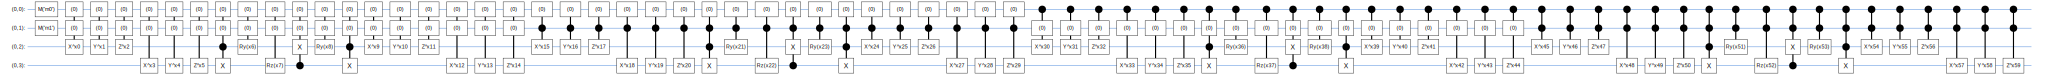

In [350]:
test_bits = cirq.GridQubit.rect(1, 4)

SVGCircuit(
    quantum_branch_conv_circuit(test_bits, sympy.symbols('x0:60')))

In [351]:
def create_qcnn_circuit(qubits):
    """creates a qcnn circuit"""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:66')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:45])
    model_circuit += quantum_branch_pool_circuit(qubits, symbols[45:51])
    model_circuit += quantum_conv_circuit(qubits[2:], symbols[51:66])
    return model_circuit

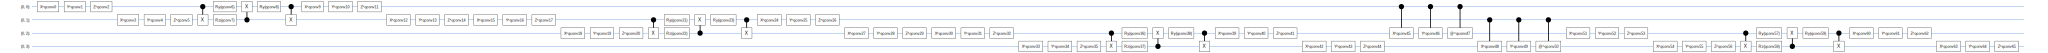

In [352]:
test_bits = cirq.GridQubit.rect(1, 4)

SVGCircuit(
    create_qcnn_circuit(test_bits))

In [353]:
def create_bqcnn_circuit(qubits):
    """creates a bqcnn circuit"""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:111')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:45]) # 3 * 15 
    model_circuit += quantum_branch_pool_circuit(qubits, symbols[45:51]) # 2 * 3
    model_circuit += quantum_branch_conv_circuit(qubits, symbols[51:111]) # 4 * 15
    return model_circuit

In [354]:
test_bits = cirq.GridQubit.rect(1, 4)

SVGCircuit(
    create_bqcnn_circuit(test_bits))

In [355]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

# CNN Definition

### Defining QCNN

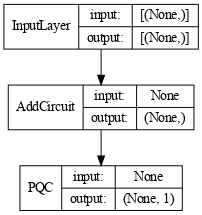

In [359]:
# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, 4)
readout_operators = cirq.Z(cluster_state_bits[-1])

# input layer
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

# declare the quantum neural network layer using tensorflow quantum Parameterized Quantum Circuit (PQC)
quantum_model = tfq.layers.PQC(create_qcnn_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

### Defining bQCNN

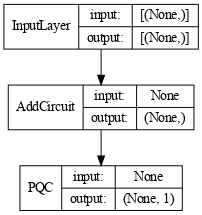

In [360]:
# input bits and readout operators
input_bits = cirq.GridQubit.rect(1, 4)
readout_operators = cirq.Z(input_bits[-1])

excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(input_bits))

# declare the quantum neural network layer using tensorflow quantum Parameterized Quantum Circuit (PQC)
quantum_model = tfq.layers.PQC(create_bqcnn_circuit(input_bits),
                               readout_operators)(cluster_state)

bqcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(bqcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

# Training

## Gradient-based Training

In [362]:
# Generate some training data.
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    input_bits)

learning_rate = 0.02
epochs = 50

### Training bQCNN


In [363]:
bqcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   loss=tf.losses.mse,
                   metrics=[tf.keras.metrics.MeanSquaredError()])

bqcnn_history = bqcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=epochs,
                         verbose=0,
                         validation_data=(test_excitations, test_labels))

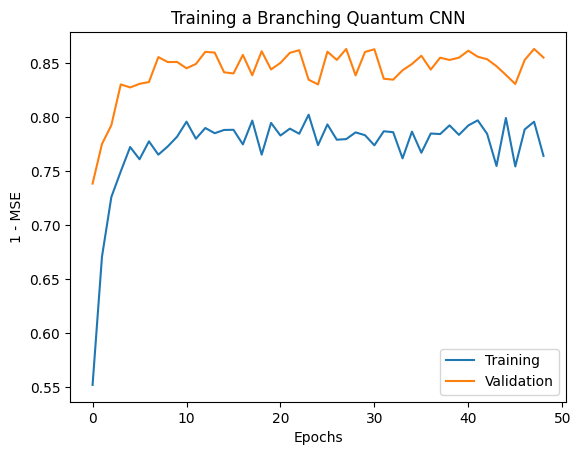

In [364]:
plt.plot(1-np.array(bqcnn_history.history['loss'][1:]), label='Training')
plt.plot(1-np.array(bqcnn_history.history['val_loss'][1:]), label='Validation')
plt.title('Training a Branching Quantum CNN')
plt.xlabel('Epochs')
plt.ylabel('1 - MSE')
plt.legend()
plt.show()

### Training QCNN

In [365]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   loss=tf.losses.mse,
                   metrics=[tf.keras.metrics.MeanSquaredError()])

qcnn_history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=epochs,
                         verbose=0,
                         validation_data=(test_excitations, test_labels))

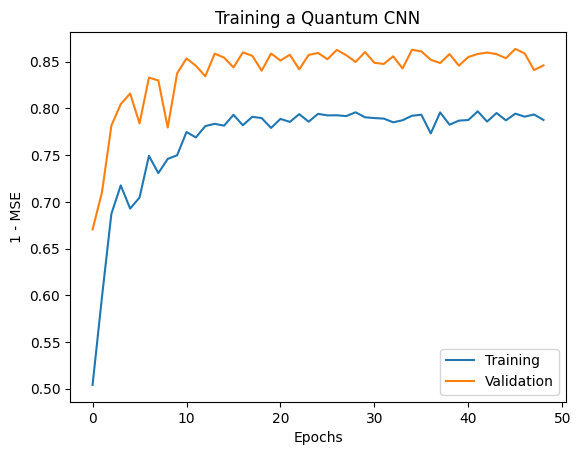

In [366]:
plt.plot(1-np.array(qcnn_history.history['loss'][1:]), label='Training')
plt.plot(1-np.array(qcnn_history.history['val_loss'][1:]), label='Validation')
plt.title('Training a Quantum CNN')
plt.xlabel('Epochs')
plt.ylabel('1 - MSE')
plt.legend()
plt.show()

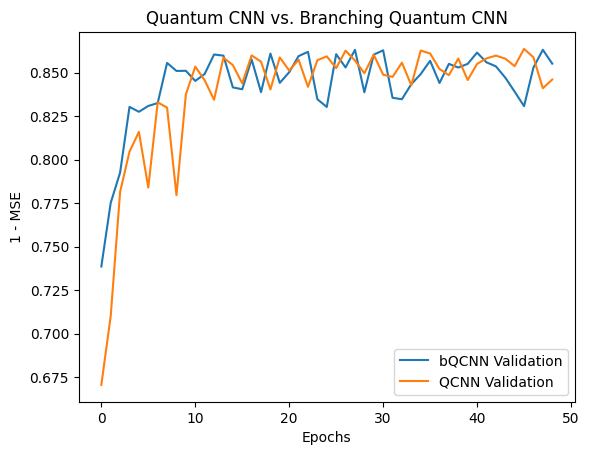

In [367]:
# plt.plot(1-np.array(bqcnn_history.history['loss'][1:]), label='bQCNN Training')
plt.plot(1-np.array(bqcnn_history.history['val_loss'][1:]), label='bQCNN Validation')
# plt.plot(1-np.array(qcnn_history.history['loss'][1:]), label='QCNN Training')
plt.plot(1-np.array(qcnn_history.history['val_loss'][1:]), label='QCNN Validation')
plt.title('Quantum CNN vs. Branching Quantum CNN')
plt.xlabel('Epochs')
plt.ylabel('1 - MSE')
plt.legend()
plt.show()